In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

In [ ]:
dfa = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/well_production/data/Copy of Volve production data.xlsx')
dfa.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


In [ ]:
dfa['NPD_FACILITY_NAME'].unique()

array(['MÆRSK INSPIRER'], dtype=object)

In [ ]:
df = dfa.copy()
# Select relevant columns
df = df[['DATEPRD','NPD_WELL_BORE_NAME','BORE_OIL_VOL']]

# Rename Columns to more appropriate names
df.rename(columns={'DATEPRD': 'Date',
                   'NPD_WELL_BORE_NAME': 'WellID',
                   'BORE_OIL_VOL': 'Production',
                   }, inplace=True)
df.head()

,Date,WellID,Production
0,2014-04-07,15/9-F-1 C,0.0
1,2014-04-08,15/9-F-1 C,0.0
2,2014-04-09,15/9-F-1 C,0.0
3,2014-04-10,15/9-F-1 C,0.0
4,2014-04-11,15/9-F-1 C,0.0


In [ ]:
# Convert the 'DateColumn' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Display the DataFrame with the updated column type
print(df.dtypes)

Date          datetime64[ns]
WellID                object
Production           float64
dtype: object


In [ ]:
# Make Date the index column
df.set_index('Date', inplace=True)

# Sort by date
df.sort_values(by='Date', inplace=True)

In [ ]:
df1 = df.copy()
df1 = df1[df1['WellID'] == '15/9-F-14']
df1.head()

,WellID,Production
Date,,
2008-02-12,15/9-F-14,0.0
2008-02-13,15/9-F-14,0.0
2008-02-14,15/9-F-14,0.0
2008-02-15,15/9-F-14,0.0
2008-02-16,15/9-F-14,0.0


In [ ]:
# Feature engineering
df1['Year'] = df1.index.year
df1['Month'] = df1.index.month
df1['Day'] = df1.index.day

# Remove the WellID column
df1.drop(columns=['WellID'], inplace=True)

# Filter off some unwanted data
df1 = df1[(df1['Year'] <= 2014)&(df1['Production'] != 0)]

df1.head()

,Production,Year,Month,Day
Date,,,,
2008-07-13,1735.26,2008,7,13
2008-07-14,592.36,2008,7,14
2008-07-15,2532.21,2008,7,15
2008-07-16,3030.71,2008,7,16
2008-07-17,3288.08,2008,7,17


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1['Production'].values.reshape(-1, 1))
scaled_data

array([[0.30690399],
       [0.10426466],
       [0.44820543],
       ...,
       [0.05113589],
       [0.06591408],
       [0.06197795]])

In [ ]:
# Prepare the training data
look_back = 10  # Number of previous time steps to use as input
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i-look_back:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

In [ ]:
# Reshape for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
# Train test split
# Split the data into training and testing sets
split_index = int(len(df1) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]
print(X_train.shape)
print(X_test.shape)

(1733, 10, 1)
(424, 10, 1)


In [ ]:
y_train = y[:split_index]
y_test = y[split_index:]
print(y_train.shape)
print(y_test.shape)

(1733,)
(424,)


In [ ]:
# Build the LSTM model
# model2 = Sequential()
# model2.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# model2.add(Dense(units=25, activation='relu'))
# model2.add(Dense(units=1, activation='linear'))


# Build the LSTM model
model2 = Sequential()
model2.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model2.add(LSTM(units=50, activation='relu'))
model2.add(Dense(units=25, activation='relu'))
model2.add(Dense(units=1, activation='linear'))


# Compile the Model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# Train the Model
model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
44/44 [==============================] - 2s 13ms/step - loss: 0.0893 - val_loss: 0.0321
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0164 - val_loss: 0.0113
Epoch 3/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0059
Epoch 4/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0123 - val_loss: 0.0039
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0121 - val_loss: 0.0027
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0024
Epoch 7/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0031
Epoch 8/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0112 - val_loss: 0.0019
Epoch 9/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0021
Epoch 10/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0052
Epoch 11

In [ ]:
# # Evaluate the Model
# if len(X_test.shape) == 1:
#     X_test = X_test.reshape(-1, 1)

loss = model2.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

14/14 [==============================] - 0s 3ms/step - loss: 0.0019
Test Loss: 0.0018641737988218665


In [ ]:
# Make predictions
predictions = model2.predict(X_test)

# Display some predictions
print(predictions[:5])

14/14 [==============================] - 0s 3ms/step
[[0.13973007]
 [0.1397816 ]
 [0.13990137]
 [0.14000916]
 [0.13998747]]


In [ ]:
# Evaluate the model
train_predict_r = model2.predict(X_train)
test_predict_r = model2.predict(X_test)

14/14 [==============================] - 0s 2ms/step


In [ ]:
# Transform the predictions back to original scale
train_predict = scaler.inverse_transform(train_predict_r)
test_predict = scaler.inverse_transform(test_predict_r)
mean_absolute_error(y_train, train_predict)

2140.9905149207625

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, test_predict)
mse = mean_squared_error(y_test, test_predict)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 665.8794001708337
Mean Squared Error (MSE): 447751.8112231438
Root Mean Squared Error (RMSE): 669.1425940882435


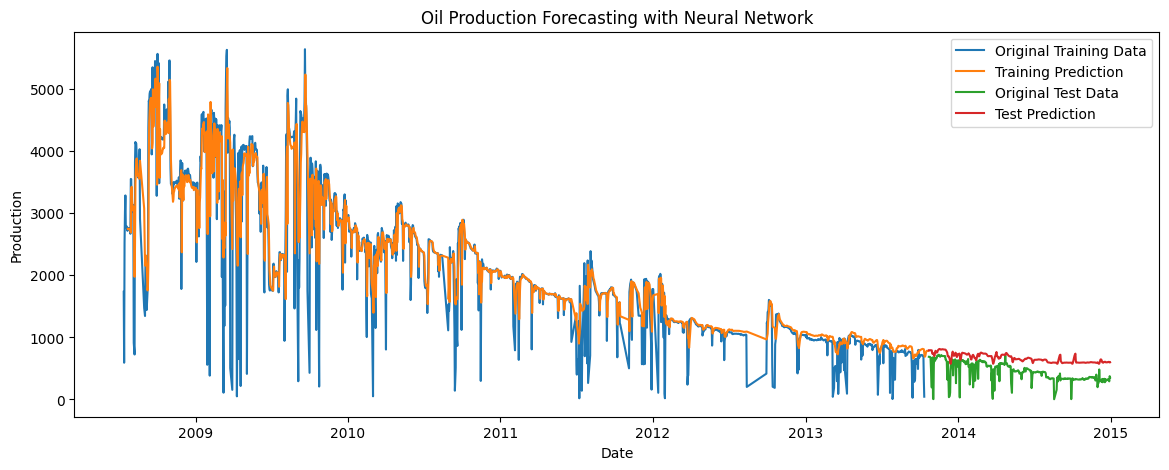

In [ ]:
# Plot the results
plt.figure(figsize=(14, 5))

# Plot training data
plt.plot(df1.index[:len(train_predict)], df1['Production'].iloc[:len(train_predict)], label='Original Training Data')
plt.plot(df1.index[look_back:len(train_predict) + look_back], train_predict, label='Training Prediction')

# Plot testing data
plt.plot(df1.index[len(train_predict) + (look_back):], df1['Production'].iloc[len(train_predict) + (look_back):], label='Original Test Data')
plt.plot(df1.index[len(train_predict) + (look_back):], test_predict, label='Test Prediction')

plt.title('Oil Production Forecasting with Neural Network')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame for training data
df_results = pd.DataFrame({'Production': df1['Production'],
                         'Prediction': np.concatenate([np.full(10, np.nan), train_predict.reshape(-1), test_predict.reshape(-1)])
                        }, index=df1.index)
df_results.tail(11)

,Production,Prediction
Date,,
2014-12-21,319.65,597.760193
2014-12-22,305.35,597.942139
2014-12-23,312.70,599.773010
2014-12-24,312.55,599.708679
2014-12-25,318.56,602.733276
2014-12-26,326.73,600.857239
2014-12-27,314.02,603.716736
2014-12-28,319.75,606.787781
2014-12-29,292.71,600.713074


In [ ]:
# Forecast into the future
future_dates = [df1.index[-1] + timedelta(days=i) for i in range(0, 30)]  # Forecasting for the next 6 months
future_dates = pd.to_datetime(future_dates)

# Create input for forecasting
# Ensure the input shape matches what your model expects (samples, time steps, features)
# For example, if your model expects 10 time steps:
# Reshape the input_data to have the correct number of features
# Assuming your model expects a single feature
input_data = df_results['Production'].values[-10:].reshape(1, 10, 1)

forecast = []

# Generate future predictions
for i in range(30):
    predicted_value = model2.predict(input_data)
    forecast.append(predicted_value[0, 0])

    # Update input_data for the next prediction
    # Ensure the new input also has the shape (1, 10, 1)
    input_data = np.append(input_data[:, 1:, :], predicted_value.reshape(1, 1, 1), axis=1)
    # Keep only the last 10 time steps
    input_data = input_data[:, -10:, :]

# Transform the forecasted data back to the original scale
# forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 [==============================] - 0s 21ms/step


In [ ]:
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])
forecast_df.index.name = 'Date'
forecast_df.head()

,Forecast
Date,
2014-12-31,148.353821
2015-01-01,-24.687035
2015-01-02,21.840830
2015-01-03,-39.893490
2015-01-04,1.901486


In [ ]:
# line plot using Plotly
import plotly.graph_objects as go # Import the plotly.graph_objects module

fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['Forecast'], mode='lines', name='Forecasted Production'))

fig.update_layout(title='Oil Production Forecast for the Next 6 Months',
                  xaxis_title='Date',
                  yaxis_title='Production',
                  showlegend=True,
                  template='plotly_dark')

# Show the plot
fig.show()

In [ ]:
import pickle

model2.save('/content/drive/MyDrive/Colab Notebooks/well_production/models/lstm_model.h5')


# # Optionally, save the model training history or other objects using pickle
# history = model2.history.history
# with open('/content/drive/MyDrive/Colab Notebooks/well_production/models/model_history.pkl', 'wb') as file:
#     pickle.dump(history, file)

In [ ]:
# Load the model using load_model
model2_loaded = load_model('/content/drive/MyDrive/Colab Notebooks/well_production/models/lstm_model.h5')

# # Optionally, load the model history or other objects using pickle
# with open('/content/drive/MyDrive/Colab Notebooks/well_production/models/model_history.pkl', 'rb') as file:
#     history_loaded = pickle.load(file)

# Now you can use model2_loaded for predictions or further training
